<a href="https://colab.research.google.com/github/securemindorg/Educational-Examples/blob/main/stock_trading_algoritmic_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Stock Trading Backtester

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # For fetching market data (optional)
import seaborn as sns # Import seaborn to make its styles available

# Set a clean style for plots
sns.set_style('whitegrid') # Using seaborn's set_style for a clean look
plt.rcParams['figure.figsize'] = (12, 8)

Load the data

In [ ]:
# Fetch historical data (e.g., SPY ETF)
ticker = "SPY"
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]  # Keep only closing prices
data.columns = ['price']  # Rename column for clarity

/tmp/ipython-input-833941313.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Add the Technical Indicators (Technical as in Stock Measures)

In [ ]:
# Calculate moving averages
data['SMA_50'] = data['price'].rolling(window=50).mean()
data['SMA_200'] = data['price'].rolling(window=200).mean()

# Drop NaN values (due to rolling window)
data.dropna(inplace=True)

Define the trading stategy

In [ ]:
# Generate signals
data['signal'] = 0  # Default: no position
data.loc[data['SMA_50'] > data['SMA_200'], 'signal'] = 1  # Buy
data.loc[data['SMA_50'] <= data['SMA_200'], 'signal'] = -1  # Sell or exit

# Calculate daily returns
data['daily_returns'] = data['price'].pct_change()

# Strategy returns (shift signals to avoid look-ahead bias)
data['strategy_returns'] = data['signal'].shift(1) * data['daily_returns']

# Cumulative returns
data['cumulative_market'] = (1 + data['daily_returns']).cumprod()
data['cumulative_strategy'] = (1 + data['strategy_returns']).cumprod()

Calc Performance Metrics

In [ ]:
# Total returns
total_market_return = data['cumulative_market'].iloc[-1] - 1
total_strategy_return = data['cumulative_strategy'].iloc[-1] - 1

# Annualized Sharpe ratio (assuming 252 trading days)
annualized_sharpe = (data['strategy_returns'].mean() / data['strategy_returns'].std()) * np.sqrt(252)

# Max drawdown
data['peak'] = data['cumulative_strategy'].cummax()
data['drawdown'] = (data['cumulative_strategy'] - data['peak']) / data['peak']
max_drawdown = data['drawdown'].min() * 100  # In percentage

Plot the Equity Curve

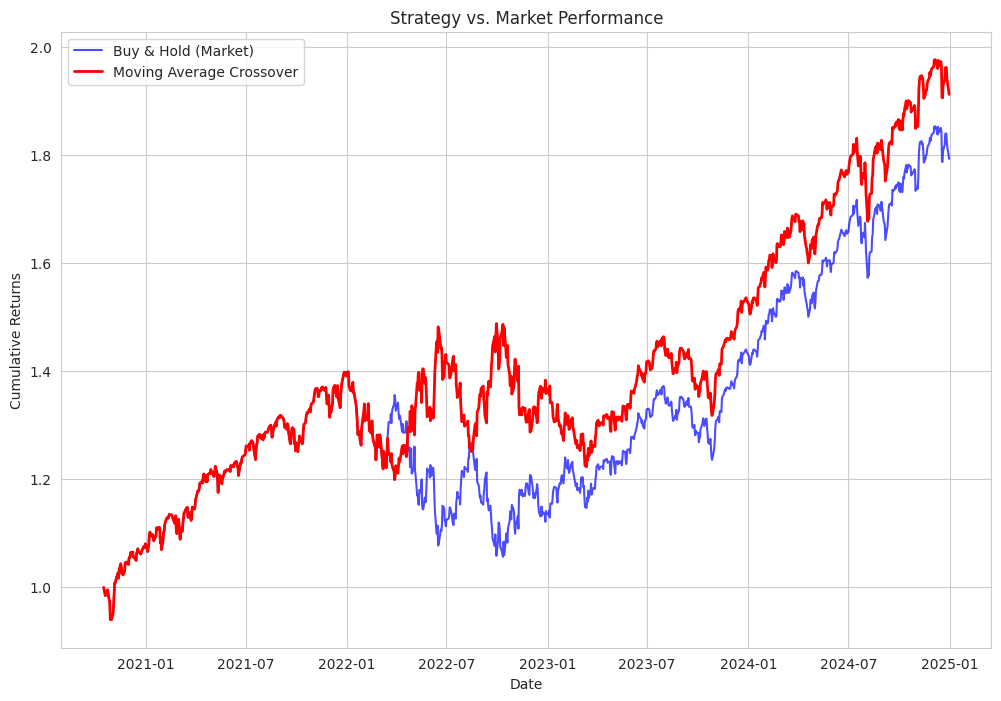

In [ ]:
plt.plot(data['cumulative_market'], label='Buy & Hold (Market)', color='blue', alpha=0.7)
plt.plot(data['cumulative_strategy'], label='Moving Average Crossover', color='red', linewidth=2)
plt.title('Strategy vs. Market Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

Plot Trades and Signals

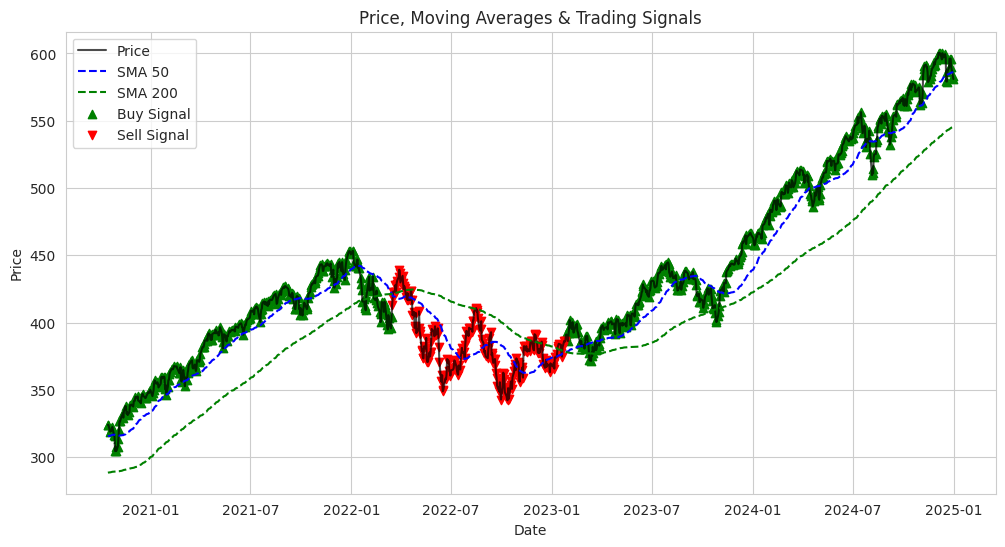

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['price'], label='Price', color='black', alpha=0.7)
plt.plot(data['SMA_50'], label='SMA 50', color='blue', linestyle='--')
plt.plot(data['SMA_200'], label='SMA 200', color='green', linestyle='--')

# Plot buy/sell signals
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['price'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['price'], label='Sell Signal', marker='v', color='red', alpha=1)

plt.title('Price, Moving Averages & Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Print performance metrics table

In [ ]:
metrics = pd.DataFrame({
    'Metric': ['Total Return (%)', 'Annualized Sharpe Ratio', 'Max Drawdown (%)'],
    'Market': [total_market_return * 100, np.nan, np.nan],
    'Strategy': [total_strategy_return * 100, annualized_sharpe, max_drawdown]
})

print("\nPerformance Metrics:")
print(metrics.to_string(index=False))


Performance Metrics:
                 Metric    Market   Strategy
       Total Return (%) 79.339442  91.270122
Annualized Sharpe Ratio       NaN   1.022121
       Max Drawdown (%)       NaN -17.812003
